In [50]:
!pip install torch torchvision

!pip install ipywidgets

You should consider upgrading via the 'C:\Users\maste\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\maste\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [52]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, MaxPool2d, ReLU, Conv2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

In [53]:
# Download the training and testing data

training_data = datasets.EMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
        split="balanced"
)

test_data = datasets.EMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
        split="balanced"
)

In [33]:
# training set contains 112800, testing set contains 18800
print('Training data:', len(training_data))
print('Test data:', len(test_data))

Training data: 112800
Test data: 18800


In [34]:
batch_size = 64

# Create train and test data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# A batch consists of 64 images, each 28x28 pixels
# Each pixel intensity is represented as a byte (0 to 255)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# define the models
class ConvNeuralNetwork(nn.Module):
    def __init__(self, conv_relu_stack=None, linear_stack=None):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_relu_stack = conv_relu_stack
        self.linear = linear_stack

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

In [36]:
# different conv_relu and linear stacks to use
stack1 = (nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.AvgPool2d(2),
            nn.ReLU()
        ),
nn.Linear(1024, 47)
)

stack2 = (nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.AvgPool2d(7),
            nn.ReLU()
        ),
nn.Linear(512, 47)
)

stack3 = (nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.AvgPool2d(9),
            nn.ReLU()
        ),
nn.Linear(128, 47)
)

stack4 = (nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.AvgPool2d(9),
            nn.ReLU()
        ),
nn.Linear(64, 47)
)

stack_list = [stack1, stack2, stack3, stack4]

In [39]:
# create the models
model_list = [ConvNeuralNetwork(stack[0], stack[1]).to(device) for stack in stack_list]

In [40]:
# train function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)

    return np.array(losses).mean()

In [41]:
# test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [8]:
# loss function and learning rate
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2

epochs = 10


model_performances = {}
for model_num, model in enumerate(model_list):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    history = {'losses': [], 'accuracies': []}
    print(f"Model {model_num}:")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
        history['accuracies'].append(test(test_dataloader, model, loss_fn))

    model_performances[model_num] = history

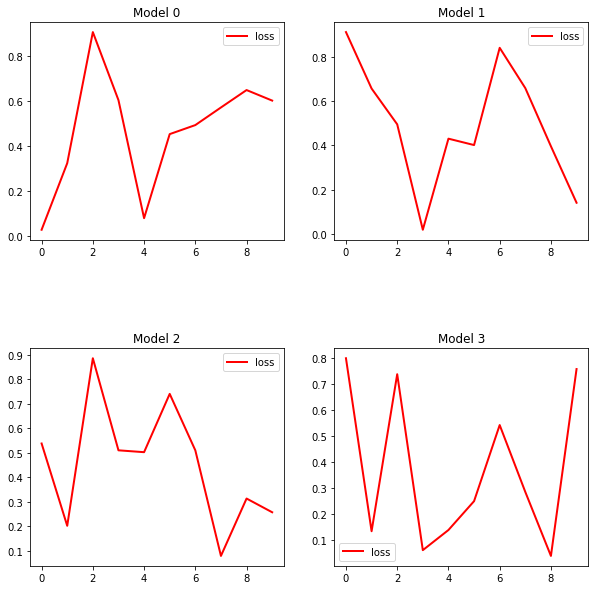

<Figure size 432x288 with 0 Axes>

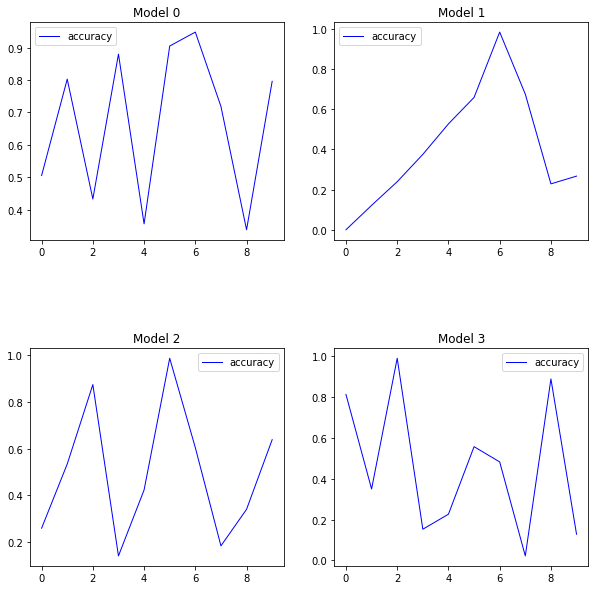

In [48]:
# visualize performances
n_rows = 2
n_cols = 2
scale = 5
plt.figure(figsize=(n_cols * scale, n_rows * scale))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.plot(model_performances[index]['losses'], 'r-', lw=2, label='loss')
        plt.legend()
        plt.title("Model " + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


plt.clf()
plt.figure(figsize=(n_cols * scale, n_rows * scale))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.plot(model_performances[index]['accuracies'], 'b-', lw=1, label='accuracy')
        plt.legend()
        plt.title("Model " + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
# best result - based on accuracy

best_model_num = -1
best_final_accuracy = 0
for model_num, model in enumerate(model_list):
    curr_acc = model_performances[model_num]["accuracies"][-1]
    if curr_acc > best_final_accuracy:
        best_final_accuracy = curr_acc
        best_model = model

print(f"The best performing model is Model {best_model_num}, with a final accuracy of {best_final_accuracy}")
print(model_list[best_model_num])